In [1]:
# import modules
import nltk
import itertools
import gensim
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.corpora as corpora
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.corpus import words
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

# Question 1

In [2]:
# As required in the assignment, we are interested for only four newsgroups. Thus, let's load only those newsgroups.
# https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(categories=categories, subset='all', remove=('headers', 'footers', 'quotes'))

In [3]:
# Let's check newsgroups
newsgroups_train.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [4]:
# Let's assign features to variable named data
data = newsgroups_train.data

In [5]:
# Let's check total number of instances in data
len(data)

3387

In [6]:
# Downloading required nltk packages
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

### Q1 (a), tokenizing the corpus and adding POS tags

In [7]:
# Here, we are performing additional operations on the word of each list other than tokenizing. 
# 1. Converting the word to lower
# 2. Removing words with only digits. For example '1', '2.5'
# 3. Splitting word from number or special characters.
#    example: if word is 'abc3ef!ghi', it will be converted as
#             ['abc', 'ef','ghi']
# example: Let's say data is like ['A B C.', 'A,', 'B C D']. After tokenization, the data would be 
# [[A,B,C], [A], [B,C,D]]
# https://www.nltk.org/api/nltk.tokenize.html
def clean_text(text_list):
    build_list = []
    for word in text_list:
        new_list = []
        flag = 0   # It will be changed to 1 if digit or special character is found in a word
        new_word = ''   # a character will be appended in this string till digit or special character is found or last index is reached
        word = word.lower()   # Change word to lower
        for i in word:
            if i.isdigit() or i in "!@#$%^&*()+`~'.":
                if (new_word != '' and len(new_word) > 1):   # remove a word with length 1 too
                    new_list.append(new_word)
                flag = 1
                new_word = ''
            else:
                new_word = new_word + i
        if (flag == 0 and len(word)>1):
            new_list.append(word)
        build_list.extend(new_list)
    return build_list
    
def sentence_to_words(sentences):
    make_list = []
    for sentence in sentences:
        temp_list = word_tokenize(sentence)
        temp_list = list(filter(lambda token: token not in string.punctuation, temp_list))   # https://stackoverflow.com/a/56847275
        temp_list = [x for x in temp_list if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]   # https://stackoverflow.com/a/3159166/8243992
        make_list.append(clean_text(temp_list))
    return make_list

data_words = sentence_to_words(data)  

In [8]:
# let's check number of words in first instance.
len(data_words[0])

107

In [9]:
# Part-of-speech tagging. The POS tagging is done using nltk library.
# https://www.nltk.org/book/ch05.html
# example: Our data would be [[(A,NN), (B,IN), (C,JJ)], [(A,NN)], [(B,IN),(C,JJ),(D,VBP)]]
def add_pos_tag(texts):
    build_list = []   # this list will be returned
    for doc in texts:
        build_list.append(nltk.pos_tag(doc))
    return build_list
data_words_pos = add_pos_tag(data_words)

In [10]:
# Let's check words and POS tag for first instance.
print(data_words_pos[0])

[('my', 'PRP$'), ('point', 'NN'), ('is', 'VBZ'), ('that', 'IN'), ('you', 'PRP'), ('set', 'VBP'), ('up', 'RP'), ('your', 'PRP$'), ('views', 'NNS'), ('as', 'IN'), ('the', 'DT'), ('only', 'JJ'), ('way', 'NN'), ('to', 'TO'), ('believe', 'VB'), ('saying', 'VBG'), ('that', 'IN'), ('all', 'DT'), ('eveil', 'NN'), ('in', 'IN'), ('this', 'DT'), ('world', 'NN'), ('is', 'VBZ'), ('caused', 'VBN'), ('by', 'IN'), ('atheism', 'NN'), ('is', 'VBZ'), ('ridiculous', 'JJ'), ('and', 'CC'), ('counterproductive', 'JJ'), ('to', 'TO'), ('dialogue', 'VB'), ('in', 'IN'), ('this', 'DT'), ('newsgroups', 'NNS'), ('see', 'VBP'), ('in', 'IN'), ('your', 'PRP$'), ('posts', 'NNS'), ('spirit', 'NN'), ('of', 'IN'), ('condemnation', 'NN'), ('of', 'IN'), ('the', 'DT'), ('atheists', 'NNS'), ('in', 'IN'), ('this', 'DT'), ('newsgroup', 'NN'), ('bacause', 'IN'), ('they', 'PRP'), ('don', 'VBP'), ('believe', 'VBP'), ('exactly', 'RB'), ('as', 'IN'), ('you', 'PRP'), ('do', 'VBP'), ('if', 'IN'), ('you', 'PRP'), ('here', 'RB'), ('to',

In [11]:
# Now, we are cleaning the data before applying collocation checking.
# It is done here because if the data is not cleaned and stop words are not removed, it is highly probable that stopwords
# will appear as collocation. Ergo, it is vital to remove stop words and perform cleaning steps in advance before 
# checking collocation.
# Q2 (a), cleaning corpus.
# Removing stopwords.
# https://www.nltk.org/book/ch02.html
# https://radimrehurek.com/gensim/utils.html
# example: Our data would be [[A, B, C], [A], [B, C]]
stop_words = stopwords.words()   # consider all stopwords instead of taking only English ones
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
data_words_nostop_words = remove_stopwords(data_words)

In [12]:
# Let's check number of words left in first intance. The reduced number indicates large number of stopwords have 
# been removed from the corpus (Below number is for first element-text of list. There are 3387 lists).
len(data_words_nostop_words[0])

45

In [13]:
# Let's stem the words.
# http://www.nltk.org/howto/stem.html
# example: Our data would be [[A, B, C], [A], [B, C]] with stemmed word.
ps = PorterStemmer()
def stem_words(texts):
    return [[ps.stem(word) for word in simple_preprocess(str(doc))] for doc in texts]
data_words_nostop_words_stem = stem_words(data_words_nostop_words)

In [14]:
# Number of words in first instance.
len(data_words_nostop_words_stem[0])

45

In [15]:
# Now, in order to check collocations, we need to generate a list containing all words of inner lists.
# Here, we have passed list with no stop words instead of stemmed words. 
# The purpose is just to get readable words.
# For example, our list till now was like [ [A,B,C], [A] , [B,C]]. We need to generate list such as
# [A,B,C,A,B,C]. Below function is written to generate such list.
def join_list(texts):
    build_list = []
    for doc in texts:
        build_list.extend(doc)
    return build_list
join_data_words_nostops = join_list(data_words_nostop_words)

In [16]:
# Let's check total number of elements in newly generated list.
len(join_data_words_nostops)

351478

### Q1 (b), identifying collocations

In [17]:
# The first method is frequency with filter.
# https://github.com/nicharuc/Collocations/blob/master/Collocations.ipynb
# https://medium.com/@nicharuch/collocations-identifying-phrases-that-act-like-individual-words-in-nlp-f58a93a2f84a
bigrams = nltk.collocations.BigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(join_data_words_nostops)
bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)

# Now, let's filter the words. To get better collocations, we can filter results such that the first word is noun/ adjective
# and the second word is noun.
# function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')   # First word should be adjective/ noun
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')   # Second word should be noun
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False
    
#filter bigrams
filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]

In [18]:
# Let's check top 20 collocations which are extracted by using frequency with filter.
freq_bi = filtered_bi[:20].bigram.values
filtered_bi[:20]

,bigram,freq
4572,"(image, processing)",126
1387,"(anonymous, ftp)",126
2193,"(computer, graphics)",112
155193,"(lord, jehovah)",92
14343,"(space, station)",89
1158,"(many, people)",86
3139,"(solar, system)",84
4152,"(source, code)",78
2626,"(space, shuttle)",76
7946,"(thanks, advance)",70


In [19]:
# The second method is by using PMI.
# https://github.com/nicharuc/Collocations/blob/master/Collocations.ipynb
bigramFinder.apply_freq_filter(20)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
        columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)

# Let's check top 20 results of collocations extracted using PMI.
pmi_bi = bigramPMITable[:20].bigram.values
bigramPMITable[:20]

,bigram,PMI
0,"(physik, unizh)",13.963643
1,"(xxxx, xxxx)",13.712581
2,"(blew, bronx)",13.615720
3,"(beauchaine, bobbe)",13.607158
4,"(sank, manhattan)",13.607158
5,"(sumex, aim)",13.449070
6,"(op_rows, op_cols)",13.393328
7,"(ico, tek)",13.253150
8,"(mcdonnell, douglas)",13.182761
9,"(bobbe, vice)",13.101147


In [20]:
# The third method is by using T-test.
# https://github.com/nicharuc/Collocations/blob/master/Collocations.ipynb
bigramTtable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.student_t)), 
                columns=['bigram','t']).sort_values(by='t', ascending=False)

# Let's check top 20 collocations extracted using T-test.
filteredT_bi = bigramTtable[bigramTtable.bigram.map(lambda x: rightTypes(x))]
T_bi = filteredT_bi[:20].bigram.values
filteredT_bi[:20]

,bigram,t
0,"(anonymous, ftp)",11.205917
1,"(image, processing)",11.159040
3,"(computer, graphics)",10.504805
4,"(lord, jehovah)",9.578048
5,"(space, station)",9.360516
6,"(solar, system)",9.102695
7,"(many, people)",8.954932
8,"(source, code)",8.805244
9,"(space, shuttle)",8.577986
11,"(thanks, advance)",8.355147


In [21]:
# The fourth method is by using Chi-sq test.
# https://github.com/nicharuc/Collocations/blob/master/Collocations.ipynb
bigramChiTable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.chi_sq)), 
            columns=['bigram','chi-sq']).sort_values(by='chi-sq', ascending=False)

# Let's check top 20 results of Chi-sq test.
chi_bi = bigramChiTable[:20].bigram.values
bigramChiTable[:20]

,bigram,chi-sq
0,"(physik, unizh)",351478.000000
1,"(ics, uci)",329507.812140
2,"(blew, bronx)",301263.428337
3,"(beauchaine, bobbe)",299480.520448
4,"(sank, manhattan)",299480.520448
5,"(xxxx, xxxx)",295335.485872
6,"(op_rows, op_cols)",258221.877050
7,"(ico, tek)",253837.999466
8,"(remote, sensing)",247158.104161
9,"(geode, ics)",241839.448920


In [22]:
# Let's print top 20 results of four methods in one table to compare them.
# https://github.com/nicharuc/Collocations/blob/master/Collocations.ipynb
bigramsCompare = pd.DataFrame([freq_bi, pmi_bi, T_bi, chi_bi]).T
bigramsCompare.columns = ['Frequency with filter', 'PMI', 'T-test with filter', 'Chi-Sq Test']
bigramsCompare

,Frequency with filter,PMI,T-test with filter,Chi-Sq Test
0,"(image, processing)","(physik, unizh)","(anonymous, ftp)","(physik, unizh)"
1,"(anonymous, ftp)","(xxxx, xxxx)","(image, processing)","(ics, uci)"
2,"(computer, graphics)","(blew, bronx)","(computer, graphics)","(blew, bronx)"
3,"(lord, jehovah)","(beauchaine, bobbe)","(lord, jehovah)","(beauchaine, bobbe)"
4,"(space, station)","(sank, manhattan)","(space, station)","(sank, manhattan)"
5,"(many, people)","(sumex, aim)","(solar, system)","(xxxx, xxxx)"
6,"(solar, system)","(op_rows, op_cols)","(many, people)","(op_rows, op_cols)"
7,"(source, code)","(ico, tek)","(source, code)","(ico, tek)"
8,"(space, shuttle)","(mcdonnell, douglas)","(space, shuttle)","(remote, sensing)"
9,"(thanks, advance)","(bobbe, vice)","(thanks, advance)","(geode, ics)"


### Q1 (c), overlap between techniques
The above table indicates that frequency and T-test gives almost same results. Similarly, many collocations of PMI and Chi-sq test are matching with different ranks. However, results from frequency method doesn't match with PMI or Chi-sq test and  results from T-test doesn't match with PMI or Chi-sq test. By observing the results, we find many collocations which exist in actual. For example, image processing, computer graphics, space station, file format, image quality, magnetic field, public domain and many more. The frequency test directly matches frequent occurences in the strings which gives higher priority to more frequently occuring collocations. In contrast, PMI method checks how many times the words occur in group and how many times independently. 

Thus, we can combine frequency and PMI results so that those collocations which have high occurences in group rather than independently, gets more priority. As mentioned above, other two methods give nearly similar results. Combination of results of frequency method and PMI methods can give collocations. It should also be considered that there are some results which are not real collocations. Thus while making combination of results of frequency method and PMI method, we can give priority to those results which occures in both methods. For example, if (A,B) gets included in results of both techniques and (C,D) only in one method with lesser priority; we should give (A,B) higher priority.

In [23]:
# Here, some results seems uninterpretable. Though, the results might be having other language other than English.
# Thus, we have tried to check collocation with only English words.
# However in the models, we will be passing all words only as the model shouldn't be made on only English words as
# those words might be significant in making models and deciding the target values.
# Let's check collocation with English words. 
# To extract such collocations, we need to filter lists in advance.
# Thus, let's repeat required steps with only English words.
data_for_english_collocations = newsgroups_train.data
data_words_for_english_collocations = sentence_to_words(data_for_english_collocations)   # tokenization

english_dict = {}   # Make dictionary of all English words, https://stackoverflow.com/a/28339791/8243992
for word in words.words():
    english_dict[word.lower()] = 1

def keep_english(texts):   # Keep only english words
    build_list = []
    for t in texts:
        make_list = []
        for word in t:
            if word in english_dict:
                make_list.append(word)
        build_list.append(make_list)
    return build_list
data_words_for_english_collocations = keep_english(data_words_for_english_collocations)

data_words_nostop_words_for_english_collocations = remove_stopwords(data_words_for_english_collocations)   # remove stop words
join_data_words_nostops_for_english_collocations = join_list(data_words_nostop_words_for_english_collocations)   # join lists

bigrams = nltk.collocations.BigramAssocMeasures()   # frequency
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(join_data_words_nostops_for_english_collocations)
bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]
freq_bi = filtered_bi[:20].bigram.values

bigramFinder.apply_freq_filter(20)   # PMI
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
        columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)
pmi_bi = bigramPMITable[:20].bigram.values

bigramTtable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.student_t)),   # T-test 
                columns=['bigram','t']).sort_values(by='t', ascending=False)
filteredT_bi = bigramTtable[bigramTtable.bigram.map(lambda x: rightTypes(x))]
t_bi = filteredT_bi[:20].bigram.values

bigramChiTable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.chi_sq)),   # Chi-sq
            columns=['bigram','chi-sq']).sort_values(by='chi-sq', ascending=False)
chi_bi = bigramChiTable[:20].bigram.values

bigramsCompare = pd.DataFrame([freq_bi, pmi_bi, t_bi, chi_bi]).T
bigramsCompare.columns = ['Frequency', 'PMI', 'T-test', 'Chi-Sq Test']
bigramsCompare

,Frequency,PMI,T-test,Chi-Sq Test
0,"(computer, graphics)","(sank, manhattan)","(computer, graphics)","(sank, manhattan)"
1,"(lord, jehovah)","(physicist, dewey)","(lord, jehovah)","(physicist, dewey)"
2,"(space, station)","(stay, bronx)","(space, station)","(san, jose)"
3,"(many, people)","(san, jose)","(solar, system)","(stay, bronx)"
4,"(solar, system)","(joseph, smith)","(many, people)","(resource, listing)"
5,"(source, code)","(resource, listing)","(source, code)","(joseph, smith)"
6,"(space, shuttle)","(thou, shalt)","(space, shuttle)","(thou, shalt)"
7,"(thanks, advance)","(bob, vice)","(thanks, advance)","(ray, tracer)"
8,"(jesus, christ)","(gamma, correction)","(jesus, christ)","(virtual, reality)"
9,"(new, york)","(po, box)","(new, york)","(ray, tracing)"


# Question 2

### Q2 (a), cleaning

In [24]:
# The cleaning steps are already performed in question 1 before stemming.

### Q2 (b), bag-of-words tf-idf weighted vector representation.

In [25]:
# Now, in order to build models the features should contain list with each list inside containg string.
# example: Our data would be [[A B C], [A], [B C]] after this operation.
def make_string_per_list(texts):
    build_list = []
    for doc in texts:
        build_list.append(" ".join(doc))
    return build_list
data_words_nostops = make_string_per_list(data_words_nostop_words_stem)

In [26]:
data_words_nostops[0]

'point set view way believ say eveil world caus atheism ridicul dialogu newsgroup see post spirit condemn atheist newsgroup bacaus believ exactli tri convert atheist fail miser want posit constantli defend agaist insult attack like seem like sorri blind get messga quot everyon els seem'

In [27]:
# CountVectorizer will assign unique numerical value to each of unique words.
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(data_words_nostops)
X_train_counts.shape

(3387, 20536)

In [28]:
# TfidfTransformer will generate tfidf matrix with generated matrix from CountVectorizer
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(3387, 20536)

### Q2 (c) part 1, splitting the data

In [29]:
# Let's split the data into train and test dataset.
# The feature here will be the tfidf matrix generated and target will be the target value of dataset.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, newsgroups_train.target, 
                                            test_size = 0.3, random_state = 90)

### Q2 (c) part 2, train SVM

Accuracy score on test data (SVC):  0.8328416912487709


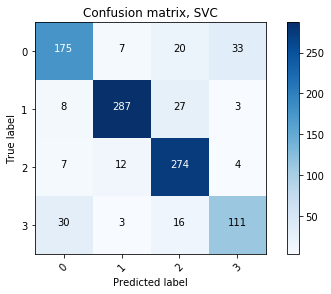

In [30]:
# Training SVM and plotting of confusion matrix
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
SVC_model = SVC(kernel='linear').fit(X_train, y_train)
predicted_svc = SVC_model.predict(X_test)
np.mean(predicted_svc == y_test)
acc_score_SVC = accuracy_score(y_test, predicted_svc)
print("Accuracy score on test data (SVC): ", acc_score_SVC)

# https://sklearn.org/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
np.set_printoptions(precision=2)
class_names = list(set(newsgroups_train.target))
conf_matrix_SVC = confusion_matrix(y_test, predicted_svc)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix_SVC, classes=class_names,
                      title='Confusion matrix, SVC')

plt.show()

### Q2 (c) part 3, train Multinomial NB

Accuracy score on test data (multinomialNB):  0.8062930186823992


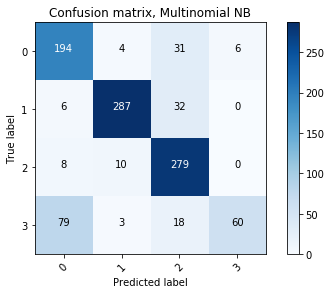

In [31]:
# Training Multinomial NB and plotting of confusion matrix
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
multinomialNB_model = MultinomialNB().fit(X_train, y_train)
predicted_multinomialNB = multinomialNB_model.predict(X_test)
acc_score_multinomialNB = accuracy_score(y_test, predicted_multinomialNB)
print("Accuracy score on test data (multinomialNB): ", acc_score_multinomialNB)

# https://sklearn.org/auto_examples/model_selection/plot_confusion_matrix.html
# Compute confusion matrix
np.set_printoptions(precision=2)
class_names = list(set(newsgroups_train.target))
conf_matrix_multinomialNB = confusion_matrix(y_test, predicted_multinomialNB)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix_multinomialNB, classes=class_names,
                      title='Confusion matrix, Multinomial NB')

plt.show()

### Q2 (c) part 4, algorithm with higher accuracy
We have computed the accuracy for SVM and Multinomial NB. The accuracy we got are as below.

SVM: 0.8328416912487709

Multinomial NB: 0.8062930186823992

The accuracy for SVM is around 3% higher than that of Multinomial NB.

The reason of SVM being more accurate lies under amount of data available. Support Vector Machine (SVM) performs better for large documents. The Multinomial Naive Bayes (NB) performs better in case of snippets. Here, the documents are available in large amount.

Another reason for SVM being more accurate is that SVM looks for dependencies between text. In contrast, Multinomial NB treats texts as independent variables. In our collocation extraction, we found that there are many considerable collocations which exist in the dataset. In addition, these collocations are available in large amount (frequency more than 50). Thus, collocations add advantage for SVM and it performs better than Multinomial NB for this dataset.

It should be also considered that combination of Multinomial NB and SVM could perform better in both cases, large document text and snippets.

https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf

### Q2 (c) part 5, change kernels of SVM

Accuracy score on test data (linear kernal SVM):  0.8328416912487709


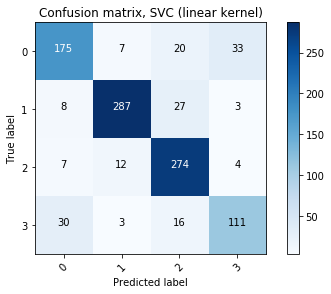

In [32]:
# Changing of kernel in SVM.
# Now, let's change kernel of SVM and check what happens with the accuracy and confusion matrix.
# First let's change kernel to linear.
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
SVC_linear_kernal_model = SVC(kernel='linear').fit(X_train, y_train)
predicted_linear_kernal_svc = SVC_linear_kernal_model.predict(X_test)
np.mean(predicted_linear_kernal_svc == y_test)
acc_score_linear_kernal_svc = accuracy_score(y_test, predicted_linear_kernal_svc)
print("Accuracy score on test data (linear kernal SVM): ", acc_score_linear_kernal_svc)

# https://sklearn.org/auto_examples/model_selection/plot_confusion_matrix.html
# Compute confusion matrix
np.set_printoptions(precision=2)
class_names = list(set(newsgroups_train.target))
conf_matrix_linear_kernal_svc = confusion_matrix(y_test, predicted_linear_kernal_svc)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix_linear_kernal_svc, classes=class_names,
                      title='Confusion matrix, SVC (linear kernel)')

plt.show()

E:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score on test data (rbf kernal SVC):  0.2920353982300885


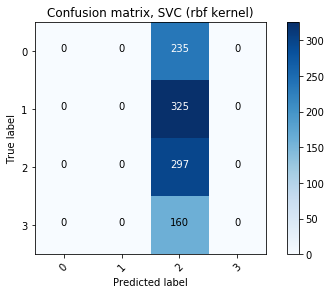

In [33]:
# Now, let's change kernel of SVM and check what happens with the accuracy and confusion matrix.
# Let's change kernel to rbf.
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
SVC_rbf_kernal_model = SVC(kernel='rbf').fit(X_train, y_train)
predicted_rbf_kernal_svc = SVC_rbf_kernal_model.predict(X_test)
np.mean(predicted_rbf_kernal_svc == y_test)
acc_score_rbf_kernal_svc = accuracy_score(y_test, predicted_rbf_kernal_svc)
print("Accuracy score on test data (rbf kernal SVC): ", acc_score_rbf_kernal_svc)

# https://sklearn.org/auto_examples/model_selection/plot_confusion_matrix.html
# Compute confusion matrix
np.set_printoptions(precision=2)
class_names = list(set(newsgroups_train.target))
conf_matrix_rbf_kernal_svc = confusion_matrix(y_test, predicted_rbf_kernal_svc)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix_rbf_kernal_svc, classes=class_names,
                      title='Confusion matrix, SVC (rbf kernel)')

plt.show()

Accuracy score on test data (sigmoid kernal SVC):  0.2920353982300885


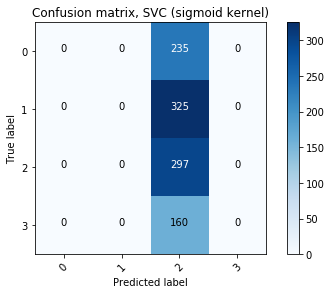

In [34]:
# Now, let's change kernel of SVM and check what happens with the accuracy and confusion matrix.
# Let's change kernel to sigmoid.
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
SVC_sigmoid_kernal_model = SVC(kernel='sigmoid').fit(X_train, y_train)
predicted_sigmoid_kernal_svc = SVC_sigmoid_kernal_model.predict(X_test)
np.mean(predicted_sigmoid_kernal_svc == y_test)
acc_score_sigmoid_kernal_svc = accuracy_score(y_test, predicted_sigmoid_kernal_svc)
print("Accuracy score on test data (sigmoid kernal SVC): ", acc_score_sigmoid_kernal_svc)

# https://sklearn.org/auto_examples/model_selection/plot_confusion_matrix.html
# Compute confusion matrix
np.set_printoptions(precision=2)
class_names = list(set(newsgroups_train.target))
conf_matrix_sigmoid_kernal_svc = confusion_matrix(y_test, predicted_sigmoid_kernal_svc)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix_sigmoid_kernal_svc, classes=class_names,
                      title='Confusion matrix, SVC (sigmoid kernel)')

plt.show()

### Observation after changing kernels

Below are the accuracies of SVC models with different kernels

Linear kernel - accuracy: 0.8328416912487709

rbf kernel - accuracy: 0.2920353982300885

sigmoid kernel - accuracy: 0.2920353982300885

We can observe that the accuracy for SVC model with rbf and sigmoid kernel remains same. The accuracy for linear kernel is much higher as compared to other two. Thus, we can conclude that the model behaves better with linear kernel.

If we consider confusion matrix, it is observed that SVC model with rbf and sigmoid kernel gives same confusion matrix. The linear kernel model gives better confusion matrix. The models with rbf and sigmoid kernel predict that all instances belong to same target i.e. 2. But actual labels contradicts the prediction of models. It results in very less accuracy for both of the models. For model with linear kernel, the confusion matrix predicts instances belonging in different targets. Though all does not match with actual results but significant amount of target predictions are correct. It results in higher accuracy for linear kernel SVC model.

### Q2 (d), models with filtered data

In [35]:
# In part d. we need to test models with only noun words. 
# Thus, let's first perform cleaning and other steps before testing the models.
# Let's load the data again.
new_data = newsgroups_train.data

In [36]:
# Total number of instances
len(new_data)

3387

In [37]:
# Tokenize sentences
new_data_words = sentence_to_words(new_data)

In [38]:
# Length of list of first instance
len(new_data_words[0])

107

In [39]:
# Add POS tag. Here, we will not filter tags with nouns.
# Before filtering the tags, we will perform cleaning as required in the assignment.
# https://www.nltk.org/book/ch05.html
new_data_words_pos = add_pos_tag(new_data_words)

In [40]:
# First instance
print(new_data_words_pos[0])

[('my', 'PRP$'), ('point', 'NN'), ('is', 'VBZ'), ('that', 'IN'), ('you', 'PRP'), ('set', 'VBP'), ('up', 'RP'), ('your', 'PRP$'), ('views', 'NNS'), ('as', 'IN'), ('the', 'DT'), ('only', 'JJ'), ('way', 'NN'), ('to', 'TO'), ('believe', 'VB'), ('saying', 'VBG'), ('that', 'IN'), ('all', 'DT'), ('eveil', 'NN'), ('in', 'IN'), ('this', 'DT'), ('world', 'NN'), ('is', 'VBZ'), ('caused', 'VBN'), ('by', 'IN'), ('atheism', 'NN'), ('is', 'VBZ'), ('ridiculous', 'JJ'), ('and', 'CC'), ('counterproductive', 'JJ'), ('to', 'TO'), ('dialogue', 'VB'), ('in', 'IN'), ('this', 'DT'), ('newsgroups', 'NNS'), ('see', 'VBP'), ('in', 'IN'), ('your', 'PRP$'), ('posts', 'NNS'), ('spirit', 'NN'), ('of', 'IN'), ('condemnation', 'NN'), ('of', 'IN'), ('the', 'DT'), ('atheists', 'NNS'), ('in', 'IN'), ('this', 'DT'), ('newsgroup', 'NN'), ('bacause', 'IN'), ('they', 'PRP'), ('don', 'VBP'), ('believe', 'VBP'), ('exactly', 'RB'), ('as', 'IN'), ('you', 'PRP'), ('do', 'VBP'), ('if', 'IN'), ('you', 'PRP'), ('here', 'RB'), ('to',

In [41]:
# Let's remove stop words now. The step will be slightly different from previous step 
# as the data contains POS tag and we need to parse data for only words.
stop_words = stopwords.words()
def remove_stopwords(texts):
    return [[word for word in doc if word[0] not in stop_words] for doc in texts]
new_data_words_nostop_words = remove_stopwords(new_data_words_pos)

In [42]:
# Length of first instance. It is decreased after removing stop words.
len(new_data_words_nostop_words[0])

46

In [43]:
# Stemming the words.
# Here, we will keep only words in the list and perform POS operation later again
# because the POS tag may change for the stemmed word.
# http://www.nltk.org/howto/stem.html
ps = PorterStemmer()
def stem_words(texts):
    build_list = []
    for doc in texts:
        new_list = []
        for word in doc:
            new_list.append(ps.stem(word[0]))
        build_list.append(new_list)
    return build_list
new_data_words_nostops = stem_words(new_data_words_nostop_words)

In [44]:
# Now, let's perform POS tagging on the stemmed data. 
# We will also filter the data to keep only nouns in the data.
# We will only keep words into the list because POS tag is not required now 
# for further operation.
# https://www.nltk.org/book/ch05.html
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def filter_pos_tag(texts):
    build_list = []   # this list will be returned
    for doc in texts:
        new_list = nltk.pos_tag(doc)
        make_list = []
        for word in new_list:
            if word[1] == 'NN' or word[1] == 'NNS' or word[1] == 'NNP' or word[1] == 'NNPS':
                make_list.append(word[0])
        build_list.append(make_list)
    return build_list
new_data_words_with_nouns = filter_pos_tag(new_data_words_nostops)

In [45]:
# Length of list of first instance. We can see that the number of words in first instance are
# decreased because we are keeping only nouns.
len(new_data_words_with_nouns[0])

32

In [46]:
# Sample list of first instance.
print(new_data_words_with_nouns[0])

['point', 'view', 'way', 'believ', 'world', 'caus', 'atheism', 'ridicul', 'counterproduct', 'dialogu', 'newsgroup', 'post', 'spirit', 'condemn', 'atheist', 'newsgroup', 'bacaus', 'believ', 'exactli', 'tri', 'atheist', 'miser', 'posit', 'constantli', 'agaist', 'insult', 'attack', 'sorri', 'blind', 'quot', 'everyon', 'els']


In [47]:
# Let's check how many total words are there in list
new_join_list = join_list(new_data_words_with_nouns)
len(new_join_list)

199652

In [48]:
# Now, to test the models, we need to combine elements of each list to string. 
# It is similar to previous steps.
new_data_words_nostops = make_string_per_list(new_data_words_with_nouns)

In [49]:
# Sample first element. It indicates that the elements are combined into one string.
new_data_words_nostops[0]

'point view way believ world caus atheism ridicul counterproduct dialogu newsgroup post spirit condemn atheist newsgroup bacaus believ exactli tri atheist miser posit constantli agaist insult attack sorri blind quot everyon els'

In [50]:
# Let's apply CountVectorizer as performed in previous section.
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(new_data_words_nostops)
X_train_counts.shape

(3387, 16702)

In [51]:
# Let's apply TfidfTransformer on CountVectorizer as performed in previous section.
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(3387, 16702)

In [52]:
# Split the data into train and test.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, newsgroups_train.target, 
                                            test_size = 0.3, random_state = 90)

Accuracy score on test data (After filtering words - SVC):  0.7935103244837758


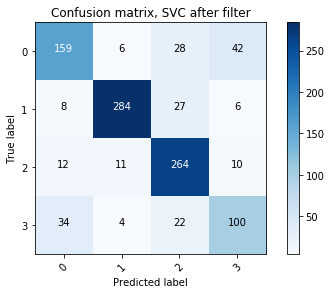

In [53]:
# Training SVM and plotting of confusion matrix
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
SVC_model_noun = SVC(kernel='linear').fit(X_train, y_train)
predicted_svc_noun = SVC_model_noun.predict(X_test)
np.mean(predicted_svc_noun == y_test)
acc_score_SVC_noun = accuracy_score(y_test, predicted_svc_noun)
print("Accuracy score on test data (After filtering words - SVC): ", acc_score_SVC_noun)

# https://sklearn.org/auto_examples/model_selection/plot_confusion_matrix.html
# Compute confusion matrix
np.set_printoptions(precision=2)
class_names = list(set(newsgroups_train.target))
conf_matrix_SVC_noun = confusion_matrix(y_test, predicted_svc_noun)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix_SVC_noun, classes=class_names,
                      title='Confusion matrix, SVC after filter')

plt.show()

Accuracy score on test data (After filtering words - multinomialNB):  0.7915437561455261


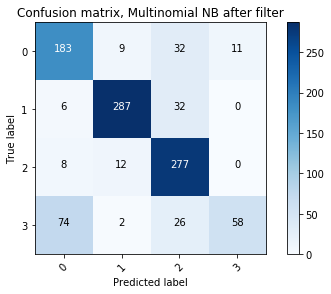

In [54]:
# Training Multinomial NB and plotting of confusion matrix
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
multinomialNB_model_noun = MultinomialNB().fit(X_train, y_train)
predicted_multinomialNB_noun = multinomialNB_model_noun.predict(X_test)
acc_score_multinomialNB_noun = accuracy_score(y_test, predicted_multinomialNB_noun)
print("Accuracy score on test data (After filtering words - multinomialNB): ", acc_score_multinomialNB_noun)

# https://sklearn.org/auto_examples/model_selection/plot_confusion_matrix.html
# Compute confusion matrix
np.set_printoptions(precision=2)
class_names = list(set(newsgroups_train.target))
conf_matrix_multinomialNB_noun = confusion_matrix(y_test, predicted_multinomialNB_noun)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix_multinomialNB_noun, classes=class_names,
                      title='Confusion matrix, Multinomial NB after filter')

plt.show()

Accuracy score on test data (After filtering words - linear kernal SVC):  0.7935103244837758


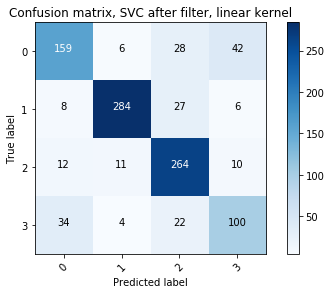

In [55]:
# Changing of kernel in SVM.
# Now, let's change kernel of SVM and check what happens with the accuracy and confusion matrix.
# First let's change kernel to linear.
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
SVC_linear_kernal_model_noun = SVC(kernel='linear').fit(X_train, y_train)
predicted_linear_kernal_svc_noun = SVC_linear_kernal_model_noun.predict(X_test)
np.mean(predicted_linear_kernal_svc_noun == y_test)
acc_score_linear_kernal_svc_noun = accuracy_score(y_test, predicted_linear_kernal_svc_noun)
print("Accuracy score on test data (After filtering words - linear kernal SVC): ", acc_score_linear_kernal_svc_noun)

# https://sklearn.org/auto_examples/model_selection/plot_confusion_matrix.html
# Compute confusion matrix
np.set_printoptions(precision=2)
class_names = list(set(newsgroups_train.target))
conf_matrix_linear_kernal_svc_noun = confusion_matrix(y_test, predicted_linear_kernal_svc_noun)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix_linear_kernal_svc_noun, classes=class_names,
                      title='Confusion matrix, SVC after filter, linear kernel')

plt.show()

E:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score on test data (After filtering words - rbf kernal SVC):  0.2920353982300885


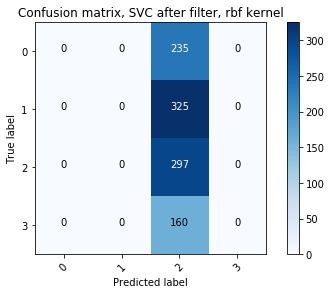

In [56]:
# Now, let's change kernel of SVM and check what happens with the accuracy and confusion matrix.
# Let's change kernel to rbf.
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
SVC_rbf_kernal_model_noun = SVC(kernel='rbf').fit(X_train, y_train)
predicted_rbf_kernal_svc_noun = SVC_rbf_kernal_model_noun.predict(X_test)
np.mean(predicted_rbf_kernal_svc_noun == y_test)
acc_score_rbf_kernal_svc_noun = accuracy_score(y_test, predicted_rbf_kernal_svc_noun)
print("Accuracy score on test data (After filtering words - rbf kernal SVC): ", acc_score_rbf_kernal_svc_noun)

# https://sklearn.org/auto_examples/model_selection/plot_confusion_matrix.html
# Compute confusion matrix
np.set_printoptions(precision=2)
class_names = list(set(newsgroups_train.target))
conf_matrix_rbf_kernal_svc_noun = confusion_matrix(y_test, predicted_rbf_kernal_svc_noun)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix_rbf_kernal_svc_noun, classes=class_names,
                      title='Confusion matrix, SVC after filter, rbf kernel')

plt.show()

Accuracy score on test data (After filtering words - sigmoid kernal SVC):  0.2920353982300885


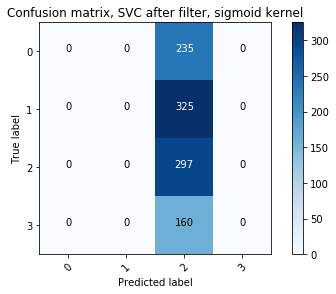

In [57]:
# Now, let's change kernel of SVM and check what happens with the accuracy and confusion matrix.
# Let's change kernel to sigmoid.
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
SVC_sigmoid_kernal_model_noun = SVC(kernel='sigmoid').fit(X_train, y_train)
predicted_sigmoid_kernal_svc_noun = SVC_sigmoid_kernal_model_noun.predict(X_test)
np.mean(predicted_sigmoid_kernal_svc_noun == y_test)
acc_score_sigmoid_kernal_svc_noun = accuracy_score(y_test, predicted_sigmoid_kernal_svc_noun)
print("Accuracy score on test data (After filtering words - sigmoid kernal SVC): ", acc_score_sigmoid_kernal_svc_noun)

# https://sklearn.org/auto_examples/model_selection/plot_confusion_matrix.html
# Compute confusion matrix
np.set_printoptions(precision=2)
class_names = list(set(newsgroups_train.target))
conf_matrix_sigmoid_kernal_svc_noun = confusion_matrix(y_test, predicted_sigmoid_kernal_svc_noun)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix_sigmoid_kernal_svc_noun, classes=class_names,
                      title='Confusion matrix, SVC after filter, sigmoid kernel')

plt.show()

### comparison of results

#### The accuracy scores
Before filtering words for nouns

SVM accuracy: 0.8328416912487709

Multinomial NB accuracy:  0.8062930186823992

After filtering words to keep nouns

SVM accuracy: 0.7935103244837758

Multinomial NB accuracy: 0.7915437561455261

It was observed that accuracy for SVM decreased around 4% after filtering nouns from words. Similarly, in Multinomial NB, the accuracy is decreased to around 1%. Thus, the filtering of words to keep nouns only did not make any significant changes in the accuracy of Multinomial NB model. But it resulted in considerable decrease in SVM model.

#### The size of vocabulary
Before filtering words for nouns: 351478

After filtering words to keep nouns: 199652

We checked total number of words in list after joining the lists. The checking was performed in previous steps as shown in above cells. The number of words in the vocabulary are as mentioned here. It is observed that the vocabulary size was reduced significantly. The data was reduced to around 57% (around 43% words removed).